In [39]:
import torch
from torchvision import datasets, transforms

# define a transform to normalize the data
# if the img has three channels, you should have three number for mean, 
# for example, img is RGB, mean is [0.5, 0.5, 0.5], the normalize result is R * 0.5, G * 0.5, B * 0.5. 
# If img is grey type that only one channel, mean should be [0.5], the normalize result is R * 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                               ])
# download and load the traning data
trainset = datasets.MNIST('data/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [49]:
# make an iterator for looping
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images[0].shape)
# NOTE: The batch size is the number of images we get in one iteration

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
torch.Size([64, 1, 28, 28])


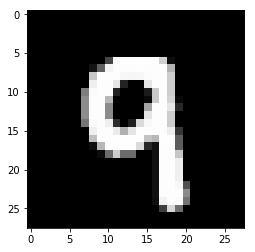

In [43]:
import matplotlib.pyplot as plt
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Time to create a dense fully-connected network. 

Each unit in one layer is connected to the other in the next layer.
The input to each layer must be one-dimensional vector. But our images are 28*28 2D tensors, so we need to convert them to 1D vectors. Therefore:
* Convert/Flatten the batch of images of shape(64, 1, 28, 28) into (64, 28 * 28=784).
* For the output layer, we also need 10 output units for the 10 classes(digits)
* Also convert the network output into a probability distribution.

In [55]:
flattened_images = images.view(64, 28 * 28)

In [56]:
print(flattened_images.shape)

torch.Size([64, 784])


In [83]:
def activation(x):
    """Create a sigmoid activation function.
    Good for outputs that fall between 0 and 1. (probability)
    args x: a torch tensor.
    """
    return 1/(1 + torch.exp(-x))

def softmax(x):
    """Create a softmax activation function.
    Good for outputs that fall between 0 and 1. (probability)
    args x: a torch tensor.
    """
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

In [84]:
# flatten the images to shape(64, 784)
inputs = images.view(images.shape[0], -1)

# create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2
probabilities = softmax(out)
print(probabilities.shape)
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Using the Torch nn to create networks

In [89]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    """Use relu(Rectified linear unit) as the activation function.
    Networks tend to train a lot faster when using relu.
    For a network to approximate a non-linear function, the activation
    function must be non-linear.
    """
    def __init__(self):
        super().__init__()
        # inputs to hidden layer linear transformation
        self.hidden_layer1 = nn.Linear(784, 128) # 256 outputs
        self.hidden_layer2 = nn.Linear(128, 64)
        # output layer, 10 units one for each digit
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # hidden layer with sigmoid activation
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        return x

In [90]:
model = Network()
model

Network(
  (hidden_layer1): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

## Training our network


In [91]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10)
                     )

# define the loss
criterion = nn.CrossEntropyLoss()

# Prepare data
images, labels = next(iter(trainloader))

# flatten images
images = images.view(images.shape[0], -1)

# forward pass, get the logits
logits = model(images)
# calculate the loss with the logits and the labels
loss = criterion(logits, labels)
print(loss)

tensor(2.3058, grad_fn=<NllLossBackward>)


It's more convenient to build model with a log-softmax output using `nn.LogSoftmax`
We can get actual probabilities by taking the exponential torch.exp(output).
We'll also use the negative log likelihood loss, `nn.NLLLoss`

In [95]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1),
                     )
criterion = nn.NLLLoss()

logits = model(images)
loss = criterion(logits, labels)
print(loss)


tensor(2.3025, grad_fn=<NllLossBackward>)
